# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
import pandas as pd
# I downloaded the pcap, then I opened in in wireshark then saved it as a csv.
netflix = pd.read_csv("../data/netflix_pcap_as_csv.csv")

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [2]:
# I asked ChatGPT to use the posted hands-on-3 as guide to filter for netflix packets

import re

# Getting DNS packets that reference Netflix domains
NF_DOMAINS = ["nflxvideo", "netflix", "nflxso", "nflxext"]

dns = netflix[netflix["Protocol"] == "DNS"].copy()
info_lower = dns["Info"].astype("string").str.lower()

nf_query_mask = False
for dom in NF_DOMAINS:
    nf_query_mask = nf_query_mask | info_lower.str.contains(dom, na=False)

nf_queries = dns[nf_query_mask].copy()
nf_queries

,No.,Time,Source,Destination,Protocol,Length,Info
86,87,1.828314,192.168.43.72,128.93.77.234,DNS,75,Standard query 0xb19a A www.netflix.com
87,88,1.828486,192.168.43.72,128.93.77.234,DNS,78,Standard query 0x3049 A assets.nflxext.com
88,89,1.828759,192.168.43.72,128.93.77.234,DNS,77,Standard query 0x5f60 A codex.nflxext.com
89,90,1.828993,192.168.43.72,128.93.77.234,DNS,86,Standard query 0x1f03 A customerevents.netflix...
90,91,1.829239,192.168.43.72,128.93.77.234,DNS,99,Standard query 0x7776 A ipv4-c001-cdg001-ix.1....
91,92,1.829530,192.168.43.72,128.93.77.234,DNS,99,Standard query 0x37e9 A ipv4-c024-cdg001-ix.1....
111,112,2.368868,192.168.43.72,128.93.77.234,DNS,99,Standard query 0x9415 A ipv4-c072-cdg001-ix.1....
118,119,2.369417,192.168.43.72,128.93.77.234,DNS,84,Standard query 0x6677 A occ-0-56-55.1.nflxso.net
1010,1011,11.262775,192.168.43.72,128.93.77.234,DNS,81,Standard query 0x5542 A push.prod.netflix.com
1515,1516,19.918496,192.168.43.72,128.93.77.234,DNS,99,Standard query 0x269f A ipv4-c005-cdg001-ix.1....


In [3]:
# Getting TXIDs for Netflix DNS queries (ChatGPT assisted)
txid_pat = r'0x[\da-fA-F]+'
nf_txids = set()
for s in nf_queries["Info"].astype(str):
    nf_txids.update(re.findall(txid_pat, s))

nf_txid_re = "|".join(sorted(nf_txids))
nf_txid_re

'0x1f03|0x269f|0x3049|0x37e9|0x3981|0x5542|0x5f60|0x6677|0x7776|0x80e9|0x82dc|0x86ee|0x9415|0xa9b1|0xb19a|0xc0b4|0xed3f'

In [4]:
# Getting Netflix DNS responses (ChatGPT assisted)
resp_mask = dns["Info"].astype(str).str.contains(nf_txid_re, regex=True, na=False) & \
            dns["Info"].astype(str).str.contains("response", case=False, na=False)
nf_responses = dns[resp_mask].copy()
nf_responses

,No.,Time,Source,Destination,Protocol,Length,Info
101,102,2.368087,128.93.77.234,192.168.43.72,DNS,539,Standard query response 0x7776 A 198.38.120.130
102,103,2.368094,128.93.77.234,192.168.43.72,DNS,545,Standard query response 0xb19a A 52.19.39.146
103,104,2.368128,128.93.77.234,192.168.43.72,DNS,534,Standard query response 0x1f03 A 52.210.19.176
104,105,2.368149,128.93.77.234,192.168.43.72,DNS,539,Standard query response 0x37e9 A 198.38.120.153
105,106,2.368176,128.93.77.234,192.168.43.72,DNS,494,Standard query response 0x3049 A 23.57.80.120
108,109,2.368630,128.93.77.234,192.168.43.72,DNS,514,Standard query response 0x5f60 A 23.57.80.120
219,220,3.108228,128.93.77.234,192.168.43.72,DNS,239,Standard query response 0x6677 A 198.38.120.137
228,229,3.135572,128.93.77.234,192.168.43.72,DNS,539,Standard query response 0x9415 A 198.38.120.167
1019,1020,11.788771,128.93.77.234,192.168.43.72,DNS,547,Standard query response 0x5542 A 34.252.77.54
1566,1567,20.241006,128.93.77.234,192.168.43.72,DNS,539,Standard query response 0x269f A 198.38.120.134


In [5]:
# Getting Netflix IPs from those DNS responses (ChatGPT assisted)
ipv4_pat = r'(?:\d{1,3}\.){3}\d{1,3}'
netflix_ips = set()
for s in nf_responses["Info"].astype(str):
    netflix_ips.update(re.findall(ipv4_pat, s))
netflix_ips

{'198.38.120.130',
 '198.38.120.134',
 '198.38.120.137',
 '198.38.120.153',
 '198.38.120.162',
 '198.38.120.164',
 '198.38.120.166',
 '198.38.120.167',
 '23.57.80.120',
 '34.252.77.54',
 '52.19.39.146',
 '52.208.128.101',
 '52.210.133.255',
 '52.210.19.176',
 '52.48.148.78',
 '52.48.8.150'}

In [6]:
# Filter ALL packets to those Netflix IPs (ChatGPT assisted)
nf_mask = netflix["Source"].isin(netflix_ips) | netflix["Destination"].isin(netflix_ips)
nf_traffic = netflix[nf_mask].copy()
nf_traffic.size

983304

In [7]:
nf_traffic.head()

,No.,Time,Source,Destination,Protocol,Length,Info
107,108,2.368591,192.168.43.72,198.38.120.130,TCP,78,58451 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...
109,110,2.368637,192.168.43.72,198.38.120.130,TCP,78,58452 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...
110,111,2.368733,192.168.43.72,198.38.120.130,TCP,78,58453 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...
112,113,2.368943,192.168.43.72,52.19.39.146,TCP,78,58454 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...
113,114,2.369006,192.168.43.72,52.19.39.146,TCP,78,58455 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [8]:
# These Stats were ChatGPT assisted 
import numpy as np

In [9]:
df = nf_traffic.copy()

df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
df["Length"] = pd.to_numeric(df["Length"], errors="coerce")
df = df.dropna(subset=["Time", "Length"])
df = df.sort_values("Time")
df = df.reset_index(drop=True)


In [10]:
# Global traffic stats

capture_start = float(df["Time"].iloc[0])
capture_end = float(df["Time"].iloc[-1])
duration_s = capture_end - capture_start
total_packets = int(len(df))
total_bytes = float(df["Length"].sum())

avg_bitrate_bps = (total_bytes * 8.0) / duration_s

print("=== Netflix Traffic Summary ===")
print("Packets:", f"{total_packets:,}")
print("Bytes:", f"{total_bytes:,.0f}")
print("Duration (s):", f"{duration_s:.3f}")
print("Average bitrate (Mbps):", f"{avg_bitrate_bps/1e6:.3f}")

=== Netflix Traffic Summary ===
Packets: 140,472
Bytes: 134,342,215
Duration (s): 493.396
Average bitrate (Mbps): 2.178


In [11]:
# Packet-level distributions
df["iat"] = df["Time"].diff()

print("\nPacket size (bytes):")
pkt_desc = df["Length"].describe()
print("count:", int(pkt_desc["count"]))
print("mean:", f"{pkt_desc['mean']:.3f}")
print("std:", f"{pkt_desc['std']:.3f}")
print("min:", f"{pkt_desc['min']:.3f}")
print("50%:", f"{pkt_desc['50%']:.3f}")
print("max:", f"{pkt_desc['max']:.3f}")

print("\nInter-arrival time (s):")
iat_desc = df["iat"].describe()
print("count:", int(iat_desc["count"]))
print("mean:", f"{iat_desc['mean']:.6f}")
print("std:", f"{iat_desc['std']:.6f}")
print("min:", f"{iat_desc['min']:.6f}")
print("50%:", f"{iat_desc['50%']:.6f}")
print("max:", f"{iat_desc['max']:.6f}")


Packet size (bytes):
count: 140472
mean: 956.363
std: 701.368
min: 54.000
50%: 1514.000
max: 1514.000

Inter-arrival time (s):
count: 140471
mean: 0.003512
std: 0.059638
min: 0.000000
50%: 0.000455
max: 5.281385


In [12]:
# Per-flow summary

# flow keys so (A,B) and (B,A) are the same flow
keys = []
for packet in range(total_packets):
    row = df.iloc[packet]
    a = str(row["Source"])
    b = str(row["Destination"])
    if a <= b:
        key = (a, b)
    else:
        key = (b, a)
    keys.append(key)

df["flow_bidir"] = keys

# Aggregate per flow
g = df.groupby("flow_bidir", as_index=True)
flow = g.agg(
    packets=("flow_bidir", "size"),
    bytes=("Length", "sum"),
    t_first=("Time", "min"),
    t_last=("Time", "max"),
)

# Duration and throughput (Mbps)
flow["duration_s"] = flow["t_last"] - flow["t_first"]

throughput = []
m = len(flow)
for i in range(m):
    b = float(flow["bytes"].iloc[i])
    d = float(flow["duration_s"].iloc[i])
    if d > 0.0:
        val = (b * 8.0 / d) / 1e6
    else:
        val = np.nan
    throughput.append(val)

flow["throughput_Mbps"] = throughput

cols = ["packets", "bytes", "duration_s", "throughput_Mbps"]
flow = flow[cols]
flow = flow.sort_values("bytes", ascending=False)

print("\nTop 5 flows by bytes:")
flow.head(5)


Top 5 flows by bytes:


,packets,bytes,duration_s,throughput_Mbps
flow_bidir,,,,
"(192.168.43.72, 198.38.120.166)",127986,123964470,475.478319,2.085722
"(192.168.43.72, 198.38.120.164)",8043,7382603,475.487773,0.124211
"(192.168.43.72, 23.57.80.120)",1839,1392549,373.620743,0.029817
"(192.168.43.72, 52.19.39.146)",961,688471,430.839566,0.012784
"(192.168.43.72, 198.38.120.162)",604,454339,75.136152,0.048375


**Write a brief justification for the features that you have chosen.**

- Interal Arrival Time Description: Reveals burstiness of the traffic
- Packet Size Description: General description of the packet behavior
- Packet Counts: Shows volume of traffic
- Byte Counts: Shows volume of traffic
- Durration of Flow: How long each flow was active. Differentiates between long streams and short segments
- Mbps bitrate: Potentially shows video quality and streaming performance.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [13]:
# This was AI assisted as well.

window_size = 5.0
gap_threshold = 1.0

# assign window index - what window are you in?
df = df.sort_values("Time").copy()
df["window"] = (df["Time"] // window_size).astype(int)

# Segment start detection per flow. is there a new segment?
df["gap_s"] = df.groupby("flow_bidir")["Time"].diff().fillna(np.inf)
df["segment_start"] = (df["gap_s"] >= gap_threshold).astype(int)

# segments per window
segments_per_window = (
    df.groupby("window")["segment_start"].sum()
      .rename("segments_per_window")
)

# segments per second within the window
segment_feature = segments_per_window.to_frame()
segment_feature["segment_rate_per_s"] = segment_feature["segments_per_window"] / window_size


segment_feature["window_start_s"] = segment_feature.index * window_size

segment_feature = segment_feature[[
    "window_start_s",
    "segments_per_window",
    "segment_rate_per_s"
]]

segment_feature.head(20)

,window_start_s,segments_per_window,segment_rate_per_s
window,,,
0,0.0,8,1.6
1,5.0,7,1.4
2,10.0,4,0.8
3,15.0,10,2.0
4,20.0,11,2.2
5,25.0,4,0.8
6,30.0,4,0.8
7,35.0,1,0.2
8,40.0,2,0.4


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [14]:
pickle_data = pd.read_pickle("../data/netflix_dataset.pkl")

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [15]:
pickle_data[(pickle_data["resolution"] == 240) |
            (pickle_data["resolution"] == 360) |
            (pickle_data["resolution"] == 480) |
            (pickle_data["resolution"] == 720) |
            (pickle_data["resolution"] == 1080)]
pickle_data["resolution"]

208       360.0
209       360.0
210       360.0
211       360.0
212       480.0
          ...  
200634    480.0
200635    480.0
200636    480.0
200637    480.0
200638      0.0
Name: resolution, Length: 52279, dtype: float64

In [16]:
a = pickle_data.columns.tolist()
print(a)

['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'absolute_timestamp', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev', 'access_var', 'ads', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_50R', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_75R', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_prev_up_chunk_iat_90', 'all_prev_up_chunk_iat_90R',

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [17]:
# I am deciding to focus on about 10 features that will help me predict resolution and quality.
# 251 is a crazy amount of columns so I am focusing on 10ish that I feel will be helpful.

labels = ["resolution"]
features = ["bitrate", "userAvgRetransmit",
            "c_rebufferings", "bitrate_change", "userAvgRTT", 
            "service_Video_throughput_down", "n_bitrate_switches", "startup_time",
            "all_prev_down_chunk_iat_avg"]

pickle_data[features].head(20)

,bitrate,userAvgRetransmit,c_rebufferings,bitrate_change,userAvgRTT,service_Video_throughput_down,n_bitrate_switches,startup_time,all_prev_down_chunk_iat_avg
208,582.0,21.680000,0,0.0,66511.023888,1486.591673,3,11489.685,808.400000
209,865.0,26.571429,0,283.0,80963.256836,1808.674941,2,11489.685,588.666667
210,865.0,32.652174,0,0.0,77564.131887,1863.401196,0,11489.685,574.836735
211,865.0,47.866667,0,0.0,122071.180556,1759.687930,2,11489.685,658.894737
212,1366.0,71.333333,0,501.0,75810.156250,1746.916648,2,11489.685,744.483871
213,1366.0,74.461538,0,0.0,82726.508247,2317.567715,0,11489.685,791.614286
214,1366.0,80.454545,0,0.0,77766.174316,2333.946667,0,11489.685,846.608108
215,2104.0,78.571429,0,738.0,74275.743273,2638.293035,1,11489.685,937.963855
216,2246.0,118.222222,0,142.0,78155.078125,2513.206223,1,11489.685,994.261364
217,1366.0,94.666667,0,-880.0,83313.069661,2104.279729,1,11489.685,1018.000000


In [18]:
pickle_data[labels + features].corr()

,resolution,bitrate,userAvgRetransmit,c_rebufferings,bitrate_change,userAvgRTT,service_Video_throughput_down,n_bitrate_switches,startup_time,all_prev_down_chunk_iat_avg
resolution,1.000000,0.645412,0.348376,-0.011184,0.061133,-0.073417,0.270889,-0.059240,-0.132422,-0.085850
bitrate,0.645412,1.000000,0.557205,-0.014710,0.105302,-0.100210,0.361353,-0.043808,-0.121209,0.053781
userAvgRetransmit,0.348376,0.557205,1.000000,-0.019177,-0.008962,-0.179466,0.342707,-0.112230,-0.118727,0.019343
c_rebufferings,-0.011184,-0.014710,-0.019177,1.000000,-0.005422,0.085837,-0.007152,0.022974,-0.002840,0.024747
bitrate_change,0.061133,0.105302,-0.008962,-0.005422,1.000000,-0.002665,-0.017797,0.078022,-0.000594,-0.023103
userAvgRTT,-0.073417,-0.100210,-0.179466,0.085837,-0.002665,1.000000,-0.079448,0.099407,0.096405,0.168461
service_Video_throughput_down,0.270889,0.361353,0.342707,-0.007152,-0.017797,-0.079448,1.000000,0.022362,-0.046022,-0.252893
n_bitrate_switches,-0.059240,-0.043808,-0.112230,0.022974,0.078022,0.099407,0.022362,1.000000,0.035245,-0.061002
startup_time,-0.132422,-0.121209,-0.118727,-0.002840,-0.000594,0.096405,-0.046022,0.035245,1.000000,0.174171
all_prev_down_chunk_iat_avg,-0.085850,0.053781,0.019343,0.024747,-0.023103,0.168461,-0.252893,-0.061002,0.174171,1.000000


**Briefly explain why you removed those columns.**

There are 251 columns in the dataset. I decided that I was going to only keep
about 10 or so features. I wanted to keep the model simple (at least in terms of
the amount of features). Especially since there are a number of columns that
weren't immediately obvious what they represented. I am keeping what seems to be
most important to infer resolution/quality.

Selected features explained:
- bitrate: Higher bitrate enables higher resolution
- userAvgRetransmit: Packet loss may force lower resolution
- c_rebufferings: Buffering events may indicatae quality reduction
- bitrate_change: Shows adaptive streaming behavior
- userAvgRTT: The longer it takes, may act as proxy for bad quality
- service_Video_throughput_down: If it's less, then the quality is probably worse
- n_bitrate_switches: Indicates network stability
- startup_time: Initial buffering may affect quality selection
- all_prev_down_chunk_iat_avg: Download timing patterns


I am avoiding features like quality because that gives away the answer.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [19]:
# The following was ChatGPT assisted.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Y = ["resolution", "quality"]
Y = pickle_data[labels].copy()
X = pickle_data[features].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [20]:
from sklearn.neural_network import MLPClassifier

# Honestly I'm choosing this model because it sounds cool. But also because it's 
# classifier model, so it finds discrete labels which is what I'm after, as
# resolution is discrete. Additionally, I understand that this model can capture
# non-linear relationships which may be present. 
mlp = MLPClassifier()

mlp.fit(X_train_scaled, Y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,hidden_layer_sizes,"(100,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [21]:
# inspiration from Claude

from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'alpha': [0.0001, 0.01]
}

grid_search = GridSearchCV(
    MLPClassifier(max_iter=1000),
    param_grid,
    cv=3,
    scoring='f1_weighted'
)

grid_search.fit(X_train_scaled, Y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

tuned_mlp = grid_search.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.f

Best params: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Best score: 0.7987030974813228


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [22]:
# ChatGPT assisted
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

Y_pred = tuned_mlp.predict(X_test_scaled)

print("Accuracy:", accuracy_score(Y_test, Y_pred))

print("F1:", f1_score(Y_test, Y_pred, average="weighted"))

print("Confusion matrix:\n", confusion_matrix(Y_test, Y_pred))

Y_proba = tuned_mlp.predict_proba(X_test_scaled)
print("ROC-AUC:", roc_auc_score(Y_test, Y_proba, multi_class='ovr'))

Accuracy: 0.8130068859984698
F1: 0.8041477956462755
Confusion matrix:
 [[ 362    7   11  170   51   22]
 [   5  166   47  142   33    5]
 [   3   31  696  371   27    3]
 [  38   44  207 6873  152   35]
 [  18    8   20  754 1468  145]
 [   3    0    1   36   55 1061]]
ROC-AUC: 0.9398085959983445


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

Selected session: b0401163e3b2c9646e4ab015410d8400 (25 data points)


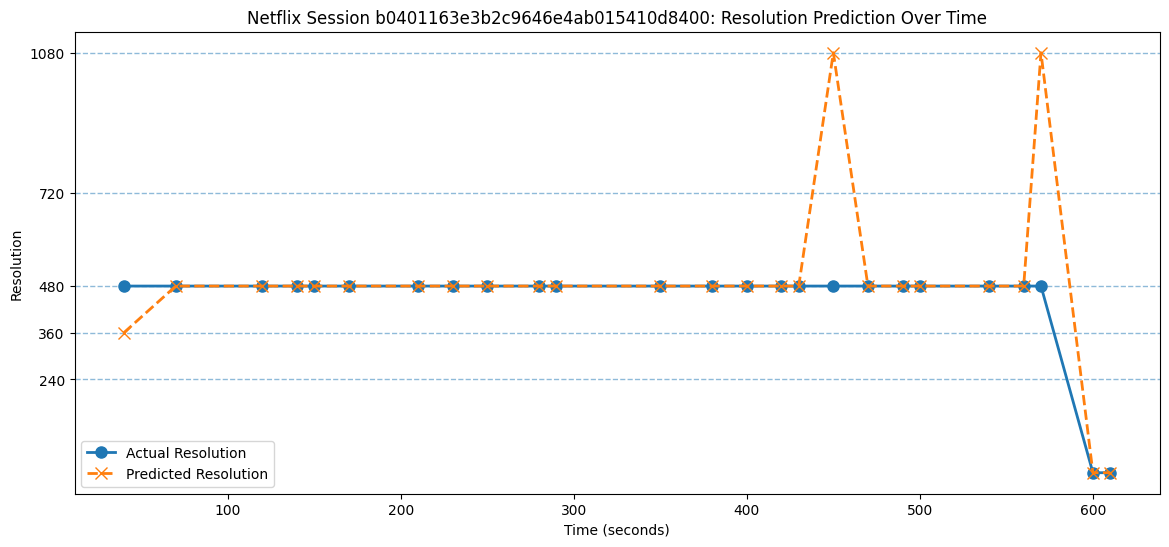

In [23]:
# AI Assisted

import matplotlib.pyplot as plt

test_idx = X_test.index
test_df = pickle_data.loc[test_idx].copy()

# predict
test_df['predicted_resolution'] = tuned_mlp.predict(X_test_scaled)

session_counts = test_df['session_id'].value_counts()

idx = 1
selected_session = session_counts.index[idx]
print(f"Selected session: {selected_session} ({session_counts.iloc[idx]} data points)")

session_df = test_df[test_df['session_id'] == selected_session].copy()
session_df = session_df.sort_values('relative_timestamp')

# Group into 10-second intervals
session_df['time_interval'] = (session_df['relative_timestamp'] // 10) * 10
interval_results = session_df.groupby('time_interval').last().reset_index()

plt.figure(figsize=(14, 6))
available_res = [240, 360, 480, 720, 1080]
for res in available_res:
    plt.axhline(y=res, linestyle='--', linewidth=1, alpha=0.5)
plt.yticks(available_res)
plt.plot(interval_results['time_interval'], interval_results['resolution'], 
         label='Actual Resolution', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.plot(interval_results['time_interval'], interval_results['predicted_resolution'], 
         label='Predicted Resolution', marker='x', linestyle='--', linewidth=2, markersize=8)
plt.xlabel('Time (seconds)')
plt.ylabel('Resolution')
plt.title(f'Netflix Session {selected_session}: Resolution Prediction Over Time')
plt.legend()
plt.show()

AI Use Disclosure:

I used AI in the process of completing this assignment. I mainly used it to
draft up some initial code, especially for parts that I am used to. I also
used it to help me with the parts that I didn't know how to do, like training
and evaluating an ML model. This is my first time doing anything ML related. I
of course checked over all code, and made any adjustments that I felt was
necessary.